In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =1e-24

nband = 1100

ng =5

ng_refs = (/ 5 /) 

nref =1

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 500 /) 

t_refs = (/ 250 /) 

tsfc =257

vstar = 1900

data w_diffuse
     &     /1.66 , 1.66 , 1.66 , 1.66,
     &     1.66/

data wgt
     &     /0.4 , 0.4 , 0.5 , 0.6,
     &     0.9/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

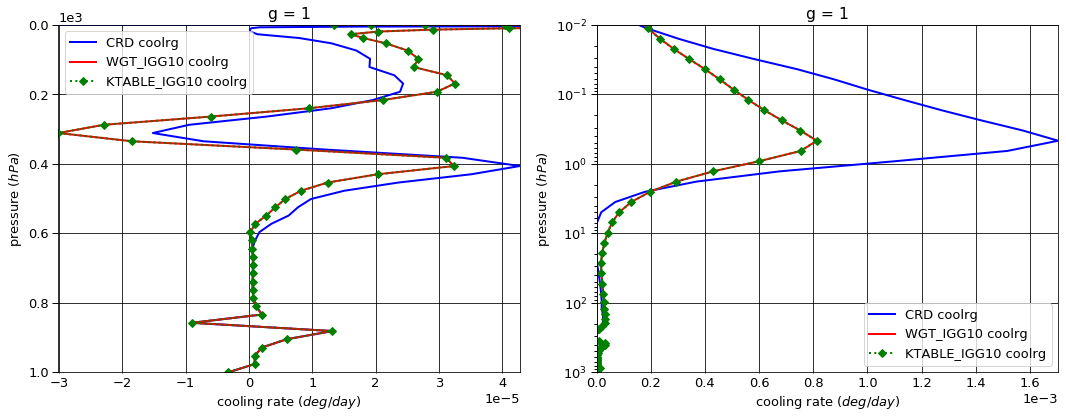

# Figure: cooling rate g-group 2

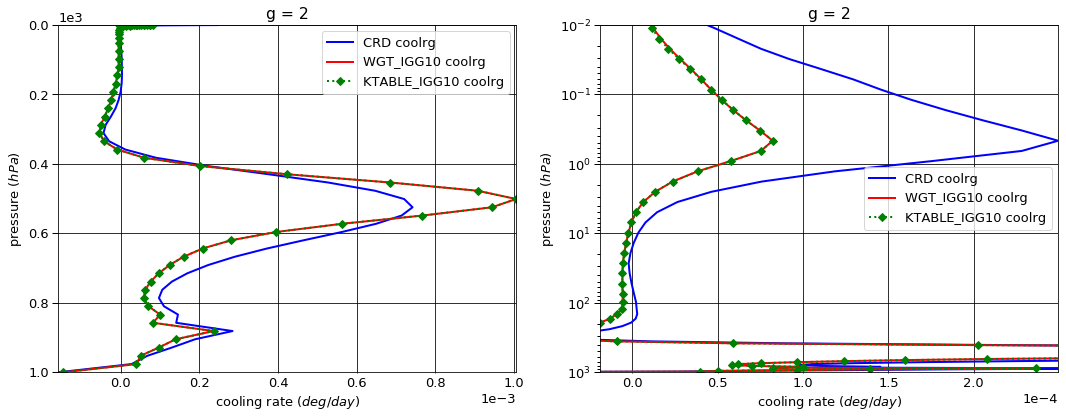

# Figure: cooling rate g-group 3

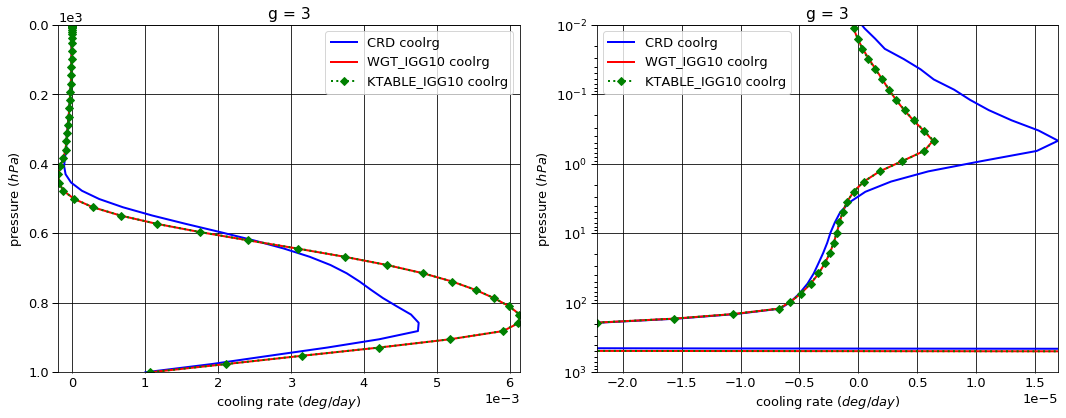

# Figure: cooling rate g-group 4

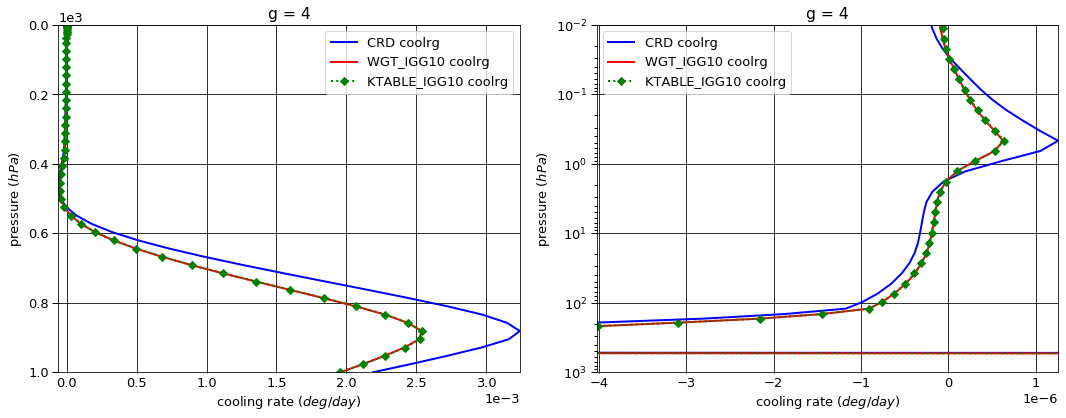

# Figure: cooling rate g-group 5

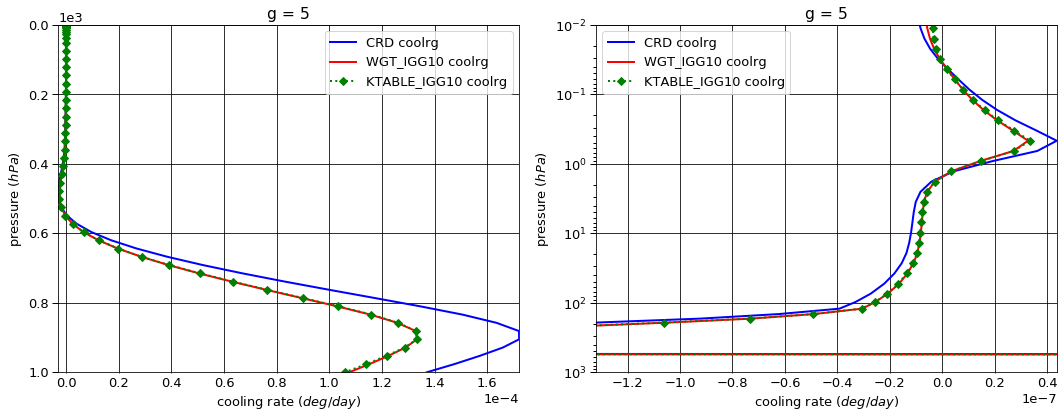

# Figure: cooling rate g-group total

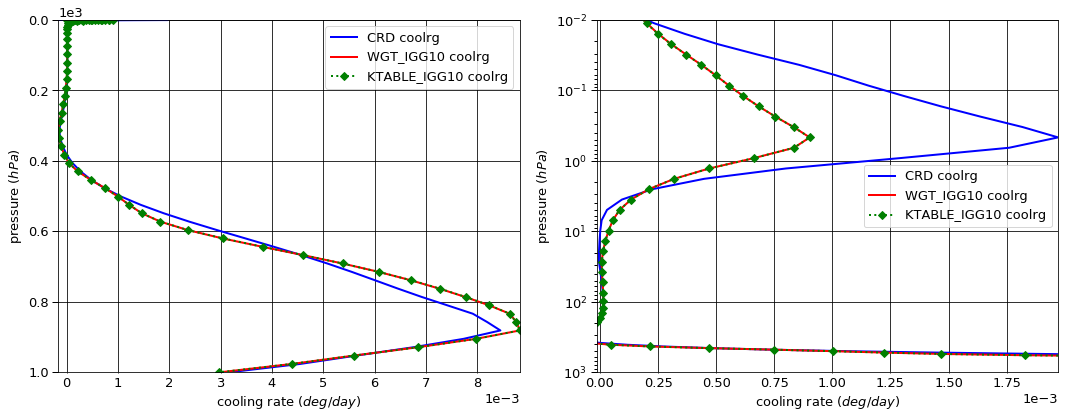

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001248  0.000000 -0.001248
  1013.0   76    -0.007708  0.007719  0.000011
2 0.0      1     -0.021572  0.000000 -0.021572
  1013.0   76    -0.059732  0.060445  0.000714
3 0.0      1     -0.222788  0.000000 -0.222788
  1013.0   76    -0.278088  0.239355 -0.038733
4 0.0      1     -0.515253  0.000000 -0.515253
  1013.0   76    -0.524466  0.114153 -0.410312
5 0.0      1     -0.596621  0.000000 -0.596621
  1013.0   76    -0.596916  0.005640 -0.591276


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001080  0.000000 -0.001080
  1013.0   76    -0.007708  0.007719  0.000011
2 0.0      1     -0.020215  0.000000 -0.020215
  1013.0   76    -0.059732  0.060264  0.000532
3 0.0      1     -0.226523  0.000000 -0.226523
  1013.0   76    -0.278088  0.269793 -0.008295
4 0.0      1     -0.518638  0.000000 -0.518638
  1013.0   76    -0.524466  0.087276 -0.437190
5 0.0      1     -0.596685  0.000000 -0.596685
  1013.0   76    -0.596916  0.004330 -0.592586


KTABLE_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.001080  0.000000 -0.001080
  1013.0   76    -0.007708  0.007719  0.000011
2 0.0      1     -0.020211  0.000000 -0.020211
  1013.0   76    -0.059732  0.060264  0.000532
3 0.0      1     -0.226428  0.000000 -0.226428
  1013.0   76    -0.278088  0.269880 -0.008208
4 0.0      1     -0.518608  0.000000 -0.518608
  1013.0   76    -0.524466  0.087443 -0.437022
5 0.0      1     -0.596682  0.000000 -0.596682
  1013.0   76    -0.596916  0.004333 -0.592583


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      1.673321e-04  0.000000  1.673321e-04
  1013.0   76     8.673617e-19  0.000000  1.694066e-21
2 0.0      1      1.357141e-03  0.000000  1.357141e-03
  1013.0   76     6.938894e-18 -0.000182 -1.817802e-04
3 0.0      1     -3.735510e-03  0.000000 -3.735510e-03
  1013.0   76     0.000000e+00  0.030438  3.043818e-02
4 0.0      1     -3.385520e-03  0.000000 -3.385520e-03
  1013.0   76     0.000000e+00 -0.026877 -2.687721e-02
5 0.0      1     -6.455000e-05  0.000000 -6.455000e-05
  1013.0   76     0.000000e+00 -0.001310 -1.309710e-03


KTABLE_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      1.673204e-04  0.000000  1.673204e-04
  1013.0   76     8.673617e-19  0.000000  1.694066e-21
2 0.0      1      1.361274e-03  0.000000  1.361274e-03
  1013.0   76     6.938894e-18 -0.000182 -1.818728e-04
3 0.0      1     -3.640900e-03  0.000000 -3.640900e-03
  1013.0   76     0.000000e+00  0.030525  3.052501e-02
4 0.0      1     -3.355510e-03  0.000000 -3.355510e-03
  1013.0   76     0.000000e+00 -0.026710 -2.671004e-02
5 0.0      1     -6.089000e-05  0.000000 -6.089000e-05
  1013.0   76     0.000000e+00 -0.001307 -1.307060e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.471664e-04
  1001.112500 75    -3.245345e-06
2 0.000312    1     -5.757450e-07
  1001.112500 75    -1.592838e-04
3 0.000312    1     -2.217089e-06
  1001.112500 75     1.007330e-03
4 0.000312    1     -2.332103e-07
  1001.112500 75     2.188815e-03
5 0.000312    1     -8.869521e-09
  1001.112500 75     1.370390e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.363907e-05
  1001.112500 75    -3.245345e-06
2 0.000312    1     -3.959968e-06
  1001.112500 75    -1.460996e-04
3 0.000312    1     -1.353969e-06
  1001.112500 75     1.071983e-03
4 0.000312    1     -1.030570e-07
  1001.112500 75     1.954830e-03
5 0.000312    1     -5.568780e-09
  1001.112500 75     1.075243e-04


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.341818e-05
  1001.112500 75    -3.245345e-06
2 0.000312    1     -3.655578e-06
  1001.112500 75    -1.461703e-04
3 0.000312    1     -1.158341e-06
  1001.112500 75     1.067564e-03
4 0.000312    1     -5.883544e-08
  1001.112500 75     1.952922e-03
5 0.000312    1     -3.290234e-09
  1001.112500 75     1.058822e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.608054e-04
  1001.112500 75    -4.235165e-22
2 0.000312    1     -3.384223e-06
  1001.112500 75     1.318415e-05
3 0.000312    1      8.631208e-07
  1001.112500 75     6.465320e-05
4 0.000312    1      1.301534e-07
  1001.112500 75    -2.339851e-04
5 0.000312    1      3.300741e-09
  1001.112500 75    -2.951467e-05


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.605845e-04
  1001.112500 75    -4.235165e-22
2 0.000312    1     -3.079833e-06
  1001.112500 75     1.311345e-05
3 0.000312    1      1.058749e-06
  1001.112500 75     6.023420e-05
4 0.000312    1      1.743749e-07
  1001.112500 75    -2.358935e-04
5 0.000312    1      5.579287e-09
  1001.112500 75    -3.115676e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.357481,0.000000,-1.357481
1013.0,76,-1.466909,0.427312,-1.039596



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.363142,0.000000,-1.363142
1013.0,76,-1.466909,0.429382,-1.037527



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-1.363010,0.000000,-1.36301
1013.0,76,-1.466909,0.429638,-1.03727



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.005661,0.000000,-0.005661
1013.0,76,0.000000,0.002069,0.002069



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.005529,0.000000,-0.005529
1013.0,76,0.000000,0.002326,0.002326


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000250
1001.112500,75,0.003171



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000008
1001.112500,75,0.002985



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.000009
1001.112500,75,0.002977



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000258
1001.112500,75,-0.000186



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.000259
1001.112500,75,-0.000194


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001336,0.005408
2,0.011914,0.041776
3,0.068623,0.194239
4,0.253773,0.361773
5,0.664355,0.396805


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.335911e-20
2,5.630332e-22
3,2.372961e-23
4,1.000109e-24
5,6.466739e-29


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.335911e-20,NaN,0.001336,0.005408,0.001336,0.005408,500.0
2,5.630332e-22,0.042146,0.011914,0.041776,0.013250,0.047184,500.0
3,2.372961e-23,0.042146,0.068623,0.194239,0.081873,0.241423,500.0
4,1.000109e-24,0.042146,0.253773,0.361773,0.335645,0.603195,500.0
5,6.466739e-29,0.000065,0.664355,0.396805,1.000000,1.000000,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog        ratio        taulyr
layer g pressure                                                          
1     1 0.000312     4.351961e-20  1.642609e-21    26.494195  1.566404e-06
      2 0.000312     5.471397e-22  1.588247e-23    34.449285  1.944956e-08
      3 0.000312     7.692188e-24  3.973973e-25    19.356417  3.444592e-10
      4 0.000312     1.959674e-25  1.961644e-26     9.989959  1.068151e-11
      5 0.000312     6.220591e-27  4.886564e-30  1272.999000  4.768190e-13
2     1 0.000750     4.418290e-20  1.651621e-21    26.751231  6.402129e-07
      2 0.000750     5.566202e-22  1.603246e-23    34.718334  7.967189e-09
      3 0.000750     7.861443e-24  4.034049e-25    19.487721  1.417495e-10
      4 0.000750     2.047235e-25  2.009686e-26    10.186841  4.489171e-12
      5 0.000750     6.477023e-27  5.084124e-30  1273.970200  1.999735e-13
3     1 0.001052     4.553632e-20  1.669768e-21    27.271041  9.243914e-07
      2 0.001052     5.763371e-22  1.633004e-23    35.293054  1.156105e-08
      3 0.001052     8.219652e-24  4.156917e-25    19.773433  2.076987e-10
      4 0.001052     2.237477e-25  2.108076e-26    10.613832  6.863567e-12
      5 0.001052     7.035834e-27  5.350949e-30  1314.875800  3.046343e-13
4     1 0.001476     4.692511e-20  1.688452e-21    27.791798  1.335067e-06
      2 0.001476     5.971073e-22  1.663341e-23    35.898076  1.679186e-08
      3 0.001476     8.606294e-24  4.285534e-25    20.082197  3.048591e-10
      4 0.001476     2.450038e-25  2.210488e-26    11.083697  1.051717e-11
      5 0.001476     7.663024e-27  5.665516e-30  1352.572800  4.654646e-13
5     1 0.002070     4.833152e-20  1.707477e-21    28.305815  1.926877e-06
      2 0.002070     6.187150e-22  1.694009e-23    36.523716  2.438756e-08
      3 0.002070     9.018873e-24  4.418466e-25    20.411772  4.477465e-10
      4 0.002070     2.684719e-25  2.315659e-26    11.593755  1.612387e-11
      5 0.002070     8.359086e-27  6.045146e-30  1382.776500  7.121545e-13
6     1 0.002904     4.975473e-20  1.726884e-21    28.811857  2.780035e-06
      2 0.002904     6.411882e-22  1.725167e-23    37.166723  3.542772e-08
      3 0.002904     9.459400e-24  4.555805e-25    20.763398  6.582281e-10
      4 0.002904     2.943796e-25  2.423586e-26    12.146446  2.473882e-11
      5 0.002904     9.132005e-27  6.519144e-30  1400.798100  1.091334e-12
7     1 0.004074     5.119394e-20  1.746728e-21    29.308481  4.009199e-06
      2 0.004074     6.645562e-22  1.757008e-23    37.823164  5.147358e-08
      3 0.004074     9.930049e-24  4.697703e-25    21.138093  9.684962e-10
      4 0.004074     3.229767e-25  2.534329e-26    12.744072  3.798123e-11
      5 0.004074     9.990685e-27  7.127747e-30  1401.661100  1.674844e-12
8     1 0.005714     5.264861e-20  1.767086e-21    29.794018  5.778829e-06
      2 0.005714     6.888529e-22  1.789780e-23    38.488126  7.479138e-08
      3 0.005714     1.043324e-23  4.844449e-25    21.536494  1.426138e-09
      4 0.005714     3.545418e-25  2.648058e-26    13.388749  5.834224e-11
      5 0.005714     1.094519e-26  7.928017e-30  1380.571500  2.573722e-12
9     1 0.008015     5.411778e-20  1.788058e-21    30.266236  8.326019e-06
      2 0.008015     7.141069e-22  1.823788e-23    39.155138  1.086876e-07
      3 0.008015     1.097146e-23  4.996498e-25    21.958298  2.101868e-09
      4 0.008015     3.893713e-25  2.765042e-26    14.081933  8.966724e-11
      5 0.008015     1.200648e-26  8.999713e-30  1334.096400  3.960269e-12
10    1 0.011243     5.560092e-20  1.809784e-21    30.722416  1.199052e-05
      2 0.011243     7.403543e-22  1.859437e-23    39.816039  1.579623e-07
      3 0.011243     1.154751e-23  5.154657e-25    22.402094  3.100400e-09
      4 0.011243     4.277991e-25  2.885759e-26    14.824489  1.378759e-10
      5 0.011243     1.318704e-26  1.045042e-29  1261.867100  6.101283e-12
11    1 0.015771     5.709722e-20  1.832454e-21    31.158877  1.726067e-05
      2 0.015771     7.676280e-22  1.897257e-23    

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
